In [1]:
import pandas as pd
import numpy as np
import random as rd
import math
import matplotlib.pyplot as plt
import time

from sklearn.cluster import DBSCAN, KMeans
from sklearn.mixture import GaussianMixture
from sklearn import metrics
from lshash.lshash import LSHash

In [2]:
def pre_data():
    #读取文件，整理数据
    df = pd.read_csv('../reco_data/trade.csv')
    df1 = df.groupby([df.vipno, df.pluno])[['amt']].sum()
    
    #这里将data转换为以vipno为行，pluno为列，便于之后处理
    data = df1.unstack(0).fillna(0).round().transpose().loc['amt']
    del data.index.name
    del data.transpose().index.name
    #data_array中每一项代表一个vipno的数组
    data_array = data.as_matrix()
    
    vipno_num = data_array.shape[0]
    vipno_len = data_array.shape[1]
    return data, data_array, vipno_num, vipno_len

In [3]:
def knn(data, data_array, vipno_len, vipno_num, k, vipno_pos, hash_size):
    lsh = LSHash(hash_size, input_dim = vipno_len )
    #将矩阵导入，生成哈希表
    for  vipno in range(vipno_num):
        #将所有vipno导入哈希表，将vipno的值作为extra_data
        lsh.index(data_array[vipno], extra_data =  data.iloc[vipno].name)
    else:
        #得到hash_table的查询结果
        hash_table =  lsh.query(data_array[vipno_pos], num_results= k + 1, distance_func="euclidean")
        result = []
        for res in hash_table:
            result.append(res[0][1])
        else:
            return result[1:]

In [4]:
def compare_kmeans(data, data_array, vipno_num):
    # 计算kmeans聚类
    start = time.clock()
    km_cluster_labels = KMeans(n_clusters = 2, random_state = 10).fit_predict(data_array)
    km_time = (time.clock() - start)
    #计算gmm聚类
    n_componets = 2
    start1 = time.clock()
    gm_cluster_labels = GaussianMixture(n_components = 2, covariance_type = 'spherical').fit(data).predict(data)
    gm_time = (time.clock() - start1)
    #比较
    main_cluster = np.argmax(np.bincount(gm_cluster_labels))
    count = 0
    for label_pos in range(0, vipno_num - 1):
        if km_cluster_labels[label_pos] == gm_cluster_labels[label_pos] - main_cluster:
            count +=1
    
    accuracy = float(count)/vipno_num
    print("Assume kmeans is real, GMM accuracy = ", accuracy)
    return km_time, gm_time

In [5]:
def compare_dbscan(data, data_array, vipno_num):
    #计算DBSCAN
    start = time.clock()
    db = DBSCAN(eps = 103, min_samples = 2).fit(data)
    db_time = (time.clock() - start)
    db_cluster_labels = db.labels_
    
    
    #计算gmm聚类
    n_componets = 2
    gm_cluster_labels = GaussianMixture(n_components = 1, covariance_type = 'spherical').fit(data_array).predict(data_array)
    
    #比较
    main_cluster = np.argmax(np.bincount(gm_cluster_labels))
    count = 0
    for label_pos in range(0, vipno_num - 1):
        if db_cluster_labels[label_pos] == gm_cluster_labels[label_pos] - main_cluster:
            count +=1
    
    accuracy = float(count)/vipno_num
    print("Assume dbscan is real, GMM accuracy = ", accuracy)
    return db_time

In [6]:
def verification(data, data_array, vipno_num, vipno_len):
    
    vipno_pos = rd.randint(0, vipno_num)

    n_component = 2
    # 计算gmm聚类
    cluster_labels = GaussianMixture(n_components = n_component, covariance_type = 'spherical').fit(data_array).predict(data_array)
    print(cluster_labels)
    labels_dic = pd.DataFrame(np.row_stack((data.index, cluster_labels))) 
    labels_dic = labels_dic.transpose().set_index(labels_dic.transpose()[0])

    for size in [0.01, 0.05, 0.1, 0.2, 0.3, 0.5]:
        for k in [1, 2, 3, 4, 5]:

            # get the result of KNN
            hash_size = int(vipno_num * size)
            results = knn(data, data_array, vipno_len, vipno_num, k, vipno_pos, hash_size)
            if len(results) < 1:
                print('For n_component = %d, hash_size = %d, k = %d: no result from KNN.\n' %(n_component, hash_size, k))

            else:
                print('For n_component = %d, hash_size = %d, k = %d, vipno_input = %d:' %(n_component, hash_size, k, results[0]))

                # cluster of the vipno itself
                cluster = labels_dic.loc[results[0]][1]

                # and compare
                for result in results:
                    cluster_result = labels_dic.loc[results[0]][1]
                    print('vipno_output: %d, result: %s' %(result, 'same' if cluster==cluster_result else 'not same.' ))
    return 

Assume kmeans is real, GMM accuracy =  0.9966442953020134
Assume dbscan is real, GMM accuracy =  0.6040268456375839
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1]
For n_component = 2, hash_size = 2, k = 1, vipno_input = 1591011326672:
vipno_output: 1591011326672, result: same
For n_component = 2, hash_size = 2, k = 2, vipno_input = 1595132332932:
vipno_output: 1595132332932, result: same
vipno_output: 2900000549289, result: same
For n_co

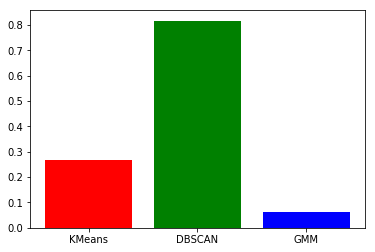

KMeans: 0.26888124739721875 DBSCAN: 0.8163646440417477 GMM: 0.06372097385018738


In [7]:
if __name__ == '__main__':
    data, data_array, vipno_num, vipno_len = pre_data()
    km_time, gm_time = compare_kmeans(data, data_array, vipno_num)
    db_time = compare_dbscan(data, data_array, vipno_num)
    verification(data, data_array, vipno_num, vipno_len)
    
    name_list = ['KMeans','DBSCAN','GMM']  
    time_list = [km_time, db_time, gm_time]  
    color_list = ['red', 'green', 'blue']
    plt.bar(range(len(time_list)), time_list,color=color_list,tick_label=name_list)  
    plt.show()  
    print('KMeans:', km_time,'DBSCAN:',db_time,'GMM:', gm_time)